# Implementation of Elo model (first version)

## Step 0: Import and checking data
We use the default dataset from www.football-data.co.uk for Brasileirão. Prior to anything else, we remove rows with missing data. This leads to the removal of one match, Chapecoense-SC x Atletico-MG in 2016, which did not happen due to a plane crash with Chapecoense's team.

In [2]:
import logging
logger = logging.getLogger("pymc")
logger.propagate = False
logger.setLevel(logging.ERROR)

from base_functions import *
test_script()

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, log_loss, recall_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
import pymc as pm
import arviz as az
from tabulate import tabulate
from itertools import chain

Script containing strategy evaluation functions were imported successfully!


In [3]:
# Imports df
try:
    df = pd.read_csv('odds_df.csv')
except:
    csv_url = "https://www.football-data.co.uk/new/BRA.csv"
    df = pd.read_csv(csv_url)


# Isolates the period under analysis and filter columns
columns_to_keep = ['Season', 'Home', 'Away', 'HG', 'AG', 'Res', 'AvgCH', 'AvgCD', 'AvgCA','MaxCH', 'MaxCD', 'MaxCA', 'PSCH', 'PSCD', 'PSCA']
df = df[columns_to_keep]
df = df.dropna(subset=columns_to_keep)

df

,Season,Home,Away,HG,AG,Res,AvgCH,AvgCD,AvgCA,MaxCH,MaxCD,MaxCA,PSCH,PSCD,PSCA
0,2012,Palmeiras,Portuguesa,1.0,1.0,D,1.69,3.50,4.90,1.76,3.87,5.31,1.75,3.86,5.25
1,2012,Sport Recife,Flamengo RJ,1.0,1.0,D,2.59,3.23,2.58,2.83,3.42,2.70,2.83,3.39,2.68
2,2012,Figueirense,Nautico,2.0,1.0,H,1.59,3.67,5.64,1.67,4.05,7.22,1.60,4.04,6.72
3,2012,Botafogo RJ,Sao Paulo,4.0,2.0,H,2.35,3.26,2.84,2.49,3.39,3.15,2.49,3.35,3.15
4,2012,Corinthians,Fluminense,0.0,1.0,A,1.89,3.33,3.89,1.96,3.53,4.41,1.96,3.53,4.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4935,2024,Flamengo RJ,Vitoria,2.0,2.0,D,1.37,5.02,7.66,1.40,5.30,8.25,1.38,5.20,7.93
4936,2024,Fortaleza,Internacional,3.0,0.0,H,2.59,3.18,2.80,2.65,3.25,2.90,2.62,3.24,2.88
4937,2024,Gremio,Corinthians,0.0,3.0,A,2.67,3.34,2.61,2.77,3.46,2.74,2.74,3.35,2.66
4938,2024,Juventude,Cruzeiro,0.0,1.0,A,2.13,3.37,3.44,2.21,3.47,3.59,2.13,3.42,3.59


## Step 1: calibrating ratings

We use seasons 2012 - 2014 for rating calibrations only. Additionally, the formulas underlying our Elo implementation are below.

Elo outcome prediction:
$$
E_H = \frac{1}{1+c^{(R_A - R_H - \omega)/d}}
$$

Elo ratings update:

$$
R'_H = R_H + k_0(1+\delta)(S_H - E_H)
$$

In [4]:
def determine_elo_outcome(row):
  '''
  Determines outcome of a match (S_H or S_A in the formula) according to Elo's standards:
  0 for loss, 0.5 for draw, 1 for victory
  '''
  if row['Res'] == 'H':
    return [1, 0]
  elif row['Res'] == 'D':
    return [0.5, 0.5]
  else:
    return [0, 1]

def elo_predict(c, d, omega, teams, ratings_dict):
  '''
  Calculates predicted Elo outcome (E_H and E_A)

  Inputs:
    c, d, omega: int
      Free variables for the formula
    teams: list
      Name of both teams in the match
    ratings_dict: dict
      Dictionary with the teams as keys and their Elo score as value

  Outputs:
    expected_home, expected_away: float
      The expected Elo outcome (E_H and E_A) for each team
    rating_difference: float
      The difference in ratings between both teams (used to inform the logistic regression)

  '''
  rating_home = ratings_dict[teams[0]]
  rating_away = ratings_dict[teams[1]]
  rating_difference = rating_home - rating_away

  exponent = (rating_away - rating_home - omega)/d

  expected_home = 1/(1 + c**exponent) # This is E_H in the formula
  expected_away = 1 - expected_home

  return expected_home, expected_away, rating_difference

def elo_update(k0, expected_home, expected_away, teams, goals, outcomes, ratings_dict):
  '''
  Updates Elo ratings for two teams based on the match outcome.

  Inputs:
    k0: int or float
      Base scaling factor used for the rating update
    expected_home, expected_away: float
      The expected outcomes for the home and away teams (E_H and E_A)
    teams: list
      Name of both teams in the match (home team first, away team second)
    goals: list
      Number of goals scored by each team ([home_goals, away_goals])
    outcomes: list
      Actual match outcomes for both teams ([home_outcome, away_outcome])
      Typically 1 for a win, 0.5 for a draw, and 0 for a loss
    ratings_dict: dict
      Dictionary with the teams as keys and their current Elo ratings as values

  Outputs:
    ratings_dict: dict
      Updated dictionary with new Elo ratings for the two teams involved in the match
  '''
  # Unpacks variables
  home = teams[0]
  away = teams[1]
  rating_home = ratings_dict[home]
  rating_away = ratings_dict[away]
  outcome_home = outcomes[0]
  outcome_away = outcomes[1]
  goal_diff = abs(goals[0] - goals[1])

  ratings_dict[home] = rating_home + k0*(1+goal_diff) * (outcome_home - expected_home)
  ratings_dict[away] = rating_away + k0*(1+goal_diff) * (outcome_away - expected_away)

  return ratings_dict

In [5]:
def adjust_teams_interseason(ratings_dict, elo_calibration_df):
  '''
  Implements the process in which promoted teams take the Elo ratings
  of demoted teams in between seasons
  '''
  # Lists all teams in previous and upcoming seasons
  old_season_teams = set(ratings_dict.keys())
  new_season_teams = set(elo_calibration_df['Home'].unique())

  # If any teams were demoted/promoted
  if len(old_season_teams - new_season_teams) != 0:
    demoted_teams = list(old_season_teams - new_season_teams)
    promoted_teams = list(new_season_teams - old_season_teams)

    # Inserts new team in the dictionary and removes the old one
    for i in range(4):
      ratings_dict[promoted_teams[i]] = ratings_dict.pop(demoted_teams[i])

  return ratings_dict

def create_elo_dict(df):
  # Creates very first dictionary with initial rating of 1000 for all teams
  teams = df[df['Season'] == 2012]['Home'].unique()
  ratings_dict = {}

  for team in teams:
      ratings_dict[team] = 1000

  return ratings_dict

In [6]:
def run_elo_calibration(df, calibration_seasons, c=10, d=400, omega=100, k0=10):
  '''
  This function iteratively adjusts team ratings based on match results over multiple seasons.

  Inputs:
    df: pandas.DataFrame
      Dataset containing match data, including columns for season, teams, goals etc.
    calibration_seasons: list
      List of seasons (or years) to be used for the calibration process
    c, d: int or float, optional (default: 10 and 400)
      Free variables for the Elo prediction formula
    omega: int or float (default=100)
      Free variable representing the advantage of the home team
    k0: int or float, optional (default=10)
      Scaling factor used to determine the influence of recent matches on team ratings

  Outputs:
    ratings_dict: dict
      Dictionary with the final Elo ratings for all teams after calibration
  '''
  # Initialize Elo ratings for all teams
  ratings_dict = create_elo_dict(df)

  # Loop through the specified calibration seasons
  for season in calibration_seasons:
    # Filter data for the current season
    season_df = df[df['Season'] == season]

    # Adjust team ratings for inter-season changes
    ratings_dict = adjust_teams_interseason(ratings_dict, season_df)

    # Iterate over each match in the current season
    for index, row in season_df.iterrows():
      # Extract team names and match information
      teams = [row['Home'], row['Away']]
      goals = [row['HG'], row['AG']]

      # Determine the actual match outcomes in Elo terms
      elo_outcomes = determine_elo_outcome(row)

      # Calculate expected outcomes using the Elo prediction formula
      expected_home, expected_away, _ = elo_predict(c, d, omega, teams, ratings_dict)

      # Update the Elo ratings based on the match results
      ratings_dict = elo_update(k0, expected_home, expected_away, teams, goals, elo_outcomes, ratings_dict)

  # Return the calibrated Elo ratings
  return ratings_dict


In [19]:
calibration_seasons = [2012, 2013, 2014]
ratings_dict = run_elo_calibration(df, calibration_seasons)

## Step 2: calibrating logit

In the seasons 2015 - 2018, we perform two processes at once. First, we keep updating the Elo ratings of all teams like before. Second, we collect additional data in each match to train a logistic regression at the end of the period. This logistic regressions will be used later on to generate predictions for each outcome and inform bets.

In [7]:
def run_logit_calibration(df, logit_seasons, ratings_dict, c=10, d=400, omega=100, k0=10):
  '''
  Runs the logistic regression calibration process for Elo ratings.

  This function calibrates Elo ratings over multiple seasons while collecting data
  (rating differences and outcomes) to prepare for training a logistic regression.
  The logistic regression is later used to make outcome predictions based on rating differences.

  Inputs:
    df: pandas.DataFrame
      Dataset containing match data, including columns for 'Season', 'Home', 'Away', 'HG', 'AG', 'Res', etc.
    logit_seasons: list
      List of seasons (or years) to be used for the logistic regression calibration process
    ratings_dict: dict
      Initial Elo ratings dictionary with teams as keys and their ratings as values
    c, d: int or float, optional (default: 10 and 400)
      Free variables for the Elo prediction formula
    omega: int or float (default=100)
      Free variable representing the advantage of the home team
    k0: int or float, optional (default=10)
      Scaling factor used to determine the influence of recent matches on team ratings


  Outputs:
    ratings_dict: dict
      Updated Elo ratings dictionary after calibration
    logit_df: pandas.DataFrame
      DataFrame containing columns 'rating_diff' (Elo rating difference between teams)
      and 'outcome' (match results) for logistic regression analysis
  '''
  # Initialize the Elo ratings dictionary
  ratings_dict = ratings_dict

  # Initialize an empty DataFrame to store rating differences and outcomes
  logit_df = pd.DataFrame(columns=['season', 'rating_diff', 'outcome'])

  # Loop through the specified seasons for logistic calibration
  for season in logit_seasons:
    # Filter data for the current season
    season_df = df[df['Season'] == season]

    # Adjust team ratings for inter-season changes
    ratings_dict = adjust_teams_interseason(ratings_dict, season_df)

    # Iterate over each match in the current season
    for index, row in season_df.iterrows():
      # Extract team names and match information
      teams = [row['Home'], row['Away']]
      goals = [row['HG'], row['AG']]

      # Determine the match outcomes in Elo terms
      elo_outcomes = determine_elo_outcome(row)

      # Calculate expected outcomes and rating difference using the Elo prediction formula
      expected_home, expected_away, rating_difference = elo_predict(c, d, omega, teams, ratings_dict)

      # Update Elo ratings based on the match results
      ratings_dict = elo_update(k0, expected_home, expected_away, teams, goals, elo_outcomes, ratings_dict)

      # Add the rating difference and match outcome to the logit DataFrame
      logit_df.loc[len(logit_df)] = {'season': season, 'rating_diff': rating_difference, 'outcome': row['Res']}

  # Return the updated ratings and the logistic regression dataset
  return ratings_dict, logit_df

In [20]:
logit_seasons = [2015, 2016, 2017, 2018]
ratings_dict, logit_df = run_logit_calibration(df, logit_seasons, ratings_dict, c=10, d=400, omega=100, k0=10)

We then fit a logistic regression adapting the base code provided by [Machine Learning Mastery](https://machinelearningmastery.com/multinomial-logistic-regression-with-python/).

In [8]:
def fit_logistic_regression(logit_df, max_past_seasons = 15, report = True):

  # Prunes the dataframe, if needed
  most_recent_seasons = sorted(logit_df['season'].unique(), reverse=True)[:max_past_seasons]
  filtered_df = logit_df[logit_df['season'].isin(most_recent_seasons)].copy()

  # Adjust outcome columns from str to int
  label_encoder = LabelEncoder()
  filtered_df['outcome_encoded'] = label_encoder.fit_transform(filtered_df['outcome'])

  # Isolates independent and dependent variables
  X = filtered_df[['rating_diff']].values
  y = filtered_df['outcome_encoded'].values
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

  # define the multinomial logistic regression model
  model = LogisticRegression(solver='lbfgs')

  # # define the model evaluation procedure
  # cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  # n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

  # fit the model on the whole dataset
  model.fit(X, y)

  # report the model performance
  if report:
    # print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

    # Generate predictions on the test data
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    # Compute key metrics
    cm = confusion_matrix(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='weighted')
    loss = log_loss(y_test, y_prob)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)

    print(f'Recall (weighted): {recall}')
    print(f'Balanced accuracy: {balanced_acc}')
    print(f'Log loss: {loss}')
    print()

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap="Blues")

  return model

## Step 3: placing bets and updating everything

For the 2019-2024 seasons, we start placing bets, with $1 staked in every match according to the outcome predicted by the logistic regression. Additionally, we re-fit the logistic regression in-between seasons.

In [9]:
def find_value_bet(model, row, rating_differece, odds_picking):

  max_value = 1
  value_bet_target = -1 # Just a random target not connected to our actual categories
  value_bet_prob = 0 # Probability of the outcome with the greatest EV

  probs = model.predict_proba([[rating_differece]])[0]

  odds_h = row['MaxCH'] if odds_picking else row['AvgCH'] 
  odds_d = row['MaxCD'] if odds_picking else row['AvgCD']
  odds_a = row['MaxCA'] if odds_picking else row['AvgCA']

  if (probs[0]*odds_a) > max_value:
    max_value = probs[0]*odds_a
    value_bet_target = 0
    value_bet_prob = probs[0]

  if (probs[1]*odds_d) > max_value:
    max_value = probs[1]*odds_d
    value_bet_target = 1
    value_bet_prob = probs[1]

  if (probs[2]*odds_h) > max_value:
    max_value = probs[2]*odds_h
    value_bet_target = 2
    value_bet_prob = probs[2]

  # if value_bet_target != -1:
  #   print(f'Target: {value_bet_target}, odds: {max_value/value_bet_prob}, prob: {value_bet_prob}, EV: {max_value}')

  return value_bet_target, value_bet_prob

In [ ]:
def run_elo_bets(df, logit_df, betting_seasons, ratings_dict, plot_title, c=10, d=400, omega=100, k0=10, max_past_seasons=15, report_ml=False, value_bet = False, odds_picking = True):
  '''
  Runs a betting simulation using Elo ratings and logistic regression to predict match outcomes.

  This function simulates placing bets on matches across multiple seasons. It uses Elo ratings
  to estimate team strengths, logistic regression for win/draw/lose predictions, and odds
  provided in the dataset to calculate returns. The function tracks performance metrics
  such as the number of bets placed, successful bets, return on bets, and final balance.

  Inputs:
    df: pandas.DataFrame
      Dataset containing match data, including columns for 'Season', 'Home', 'Away', 'HG', 'AG', 'Res', and odds (e.g., 'AvgCA', 'AvgCD', 'AvgCH').
    logit_df: pandas.DataFrame
      DataFrame containing historical Elo rating differences and match outcomes used to train the logistic regression model.
    betting_seasons: list
      List of seasons (or years) during which bets will be simulated.
    ratings_dict: dict
      Initial Elo ratings dictionary with teams as keys and their ratings as values.
    c, d: int or float, optional (default: 10 and 400)
      Free variables for the Elo prediction formula
    omega: int or float (default=100)
      Free variable representing the advantage of the home team
    k0: int or float, optional (default=10)
      Scaling factor used to determine the influence of recent matches on team ratings

  Outputs:
    cross_season_bets_placed: list
      List of the number of bets placed in each season.
    cross_season_return_on_bets: list
      List of returns for each bet placed in each season.
    cross_season_successful_bets: list
      List of the number of successful bets in each season.
    cross_season_final_balance: list
      List of the final balance at the end of each season.
  '''
  # Initialize Elo ratings and logistic regression data
  ratings_dict = ratings_dict
  logit_df = logit_df

  # Initializes lists to store results for each season
  betting_log = pd.DataFrame(columns=['Season', 'Target', 'Result', 'Successful bet', 'Profit/Loss', 'Odds locked', 'Pinnacle OIP'])

  # Loop through the specified betting seasons
  for season in betting_seasons:
   # Train the logistic regression model on the current logit_df and print performance at the last iteration
    if season == betting_seasons[-1]:
      print('\nLogistic regression performance at FINAL SEASON')
      logistic_regression = fit_logistic_regression(logit_df, max_past_seasons, report=True)
    else:
      if report_ml:
        print(f'Logistic regression performance PRE SEASON {season}')
      logistic_regression = fit_logistic_regression(logit_df, max_past_seasons, report=report_ml)

    # Filter data for the current season and adjust ratings for inter-season changes
    season_df = df[df['Season'] == season]
    ratings_dict = adjust_teams_interseason(ratings_dict, season_df)

    # Iterate over each match in the current season
    for index, row in season_df.iterrows():
      # Extract team names, goals, and match outcomes
      teams = [row['Home'], row['Away']]
      goals = [row['HG'], row['AG']]
      elo_outcomes = determine_elo_outcome(row)

      # Predict match outcomes using Elo and logistic regression
      expected_home, expected_away, rating_difference = elo_predict(c, d, omega, teams, ratings_dict)

      # Decides what to bet on
      if value_bet == True:
        yhat, _ = find_value_bet(logistic_regression, row, rating_difference, odds_picking)
      else:
        yhat = logistic_regression.predict([[rating_difference]])

      # Places bets
      if yhat != -1: # When looking for value bets, "-1" represents that no bets should be placed
        target = 'A' if yhat == 0 else 'D' if yhat == 1 else 'H'
        result = row['Res']
        successful_bet = 1 if target == result else 0
        odds_locked = row[f'MaxC{target}'] if odds_picking else row[f'AvgC{target}']
        profit_loss = (odds_locked - 1) if successful_bet else -1
        pinnacle_odds_implied_probability = (1/row[f'PSC{target}']) / ( (1/row['PSCH']) + (1/row['PSCD']) + (1/row['PSCA']) )

        # Populates betting log with info specific to each match
        betting_log.loc[len(betting_log)] = {'Season': season,
                                      'Target': target,
                                      'Result': result,
                                      'Successful bet': successful_bet,
                                      'Profit/Loss': profit_loss,
                                      'Odds locked': odds_locked,
                                      'Pinnacle OIP': pinnacle_odds_implied_probability}

      # Update Elo ratings and logistic regression dataset after the match
      ratings_dict = elo_update(k0, expected_home, expected_away, teams, goals, elo_outcomes, ratings_dict)
      logit_df.loc[len(logit_df)] = {'season': season, 'rating_diff': rating_difference, 'outcome': row['Res']}

  # Runs analysis of results and isolates posterior
  posterior_samples = summarize_results(betting_seasons, betting_log, plot_title)
  return posterior_samples, betting_log

In [11]:
def run_elo_system(df, plot_title, c=10, d=400, omega=100, k0=10, report_ml = False, value_bet = False, odds_picking = True):
    calibration_seasons = [2012, 2013, 2014]
    logit_seasons = [2015, 2016, 2017, 2018]
    betting_seasons = [2019, 2020, 2021, 2022, 2023, 2024]

    ratings_dict = run_elo_calibration(df, calibration_seasons)
    ratings_dict, logit_df = run_logit_calibration(df, logit_seasons, ratings_dict, c=c, d=d, omega=omega, k0=k0)
    posterior_samples, betting_log = run_elo_bets(df, logit_df, betting_seasons, ratings_dict, plot_title, c=c, d=d, omega=omega, k0=k0, report_ml = report_ml, value_bet = value_bet, odds_picking = odds_picking)

    return posterior_samples, betting_log

Logistic regression performance PRE SEASON 2019
Recall (weighted): 0.5032894736842105
Balanced accuracy: 0.34649122807017546
Log loss: 1.0252535522363662

Logistic regression performance PRE SEASON 2020
Recall (weighted): 0.55
Balanced accuracy: 0.37493172532826463
Log loss: 0.9626733956304049

Logistic regression performance PRE SEASON 2021
Recall (weighted): 0.4956140350877193
Balanced accuracy: 0.38208830299225777
Log loss: 1.0104086380700446

Logistic regression performance PRE SEASON 2022
Recall (weighted): 0.5169172932330827
Balanced accuracy: 0.3627354526635102
Log loss: 1.012350674334356

Logistic regression performance PRE SEASON 2023
Recall (weighted): 0.5082236842105263
Balanced accuracy: 0.4053087426965644
Log loss: 1.0152300526766562


Logistic regression performance at FINAL SEASON
Recall (weighted): 0.5
Balanced accuracy: 0.3905325443786982
Log loss: 1.014287450016929

Season-specific results
╒══════════╤═══════════════╤═══════════════════╤════════════════╤══════════════

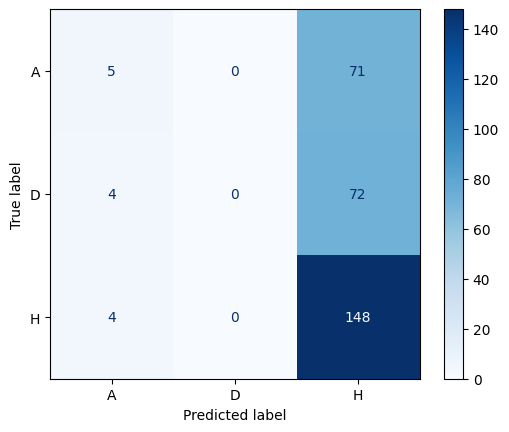

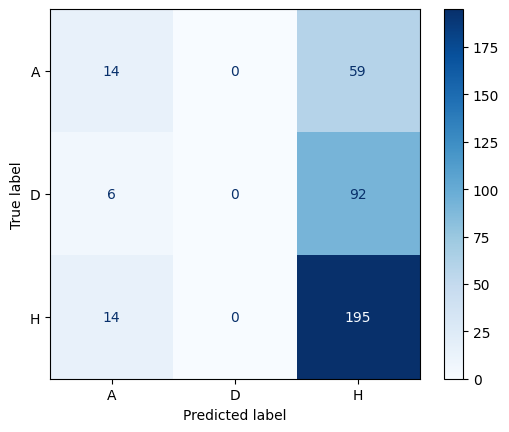

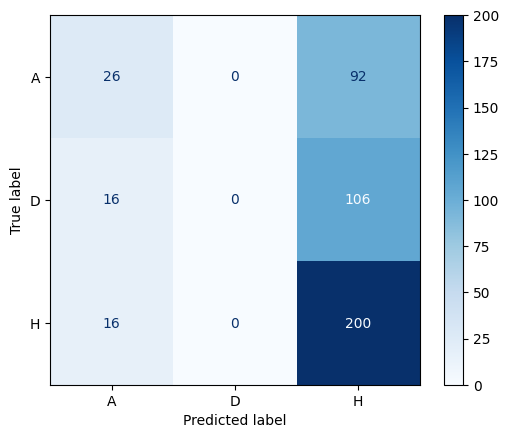

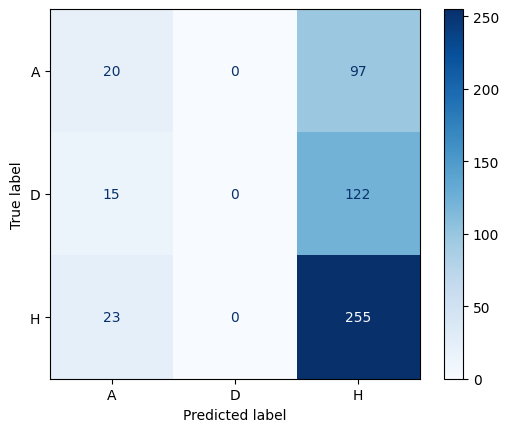

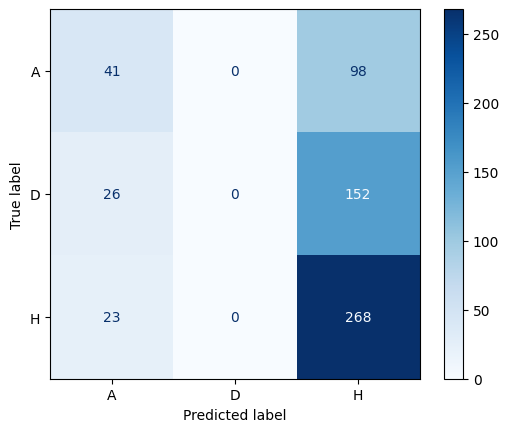

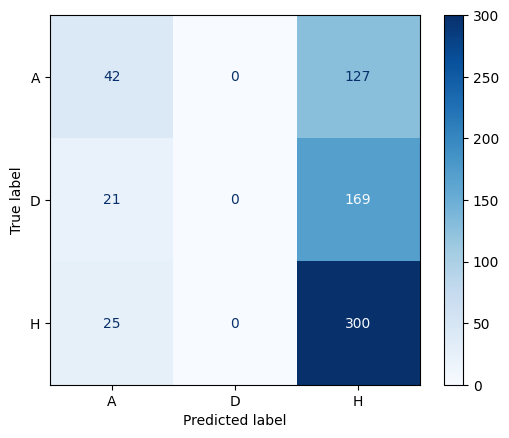

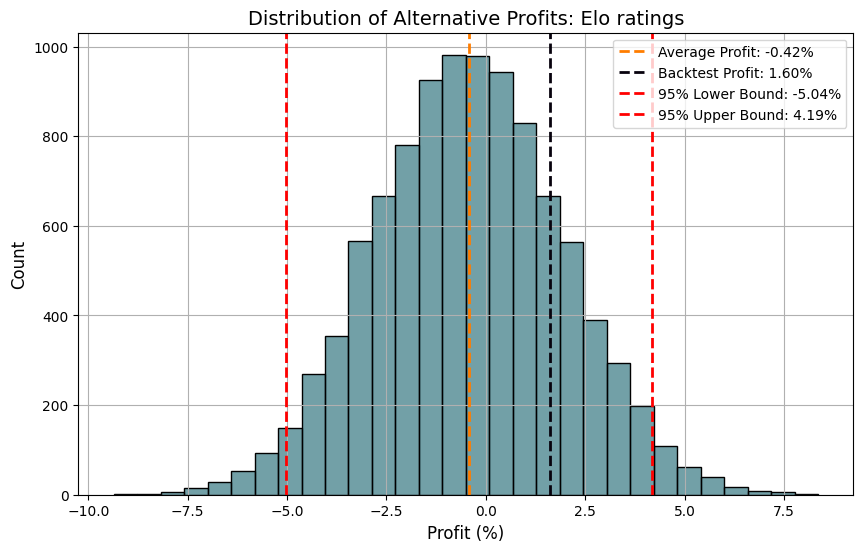


Summary of random effect analysis
  Average profit over simulations: -0.42%
  95% interval of profit: [-5.04%, 4.19%]
  Probability of ending better off than in the backtest: 19.58%
  Probability of ending with a loss: 57.46%


In [ ]:
default_elo_posterior, _ = run_elo_system(df, plot_title = 'Elo ratings', report_ml = True)

First conclusions:
1. Using Elo ratings to predict the winner of a match is, indeed, better than using traditional rankings. From a sharpness point of view, the difference between the two methods is statistically significant (p-value < 0.001). Yet, in terms of profit, following Elo is as good as always betting on the home team. Here, we have an expected profit of -0.42%, and the probability of ending with a loss is 57.4%.

We can also explore what happens when we try to use our Elo system for value bets.


Logistic regression performance at FINAL SEASON
Recall (weighted): 0.5116959064327485
Balanced accuracy: 0.38649699423180084
Log loss: 1.0062025779893662

Season-specific results
╒══════════╤═══════════════╤═══════════════════╤════════════════╤══════════════════╤════════╤══════════════╕
│  Season  │  Bets Placed  │  Successful Bets  │  Sharpness CI  │  Sharpness Mean  │  RBEP  │  Profit (%)  │
╞══════════╪═══════════════╪═══════════════════╪════════════════╪══════════════════╪════════╪══════════════╡
│   2019   │      376      │        115        │ [0.262, 0.354] │       0.31       │  0.27  │     1.11     │
├──────────┼───────────────┼───────────────────┼────────────────┼──────────────────┼────────┼──────────────┤
│   2020   │      380      │        135        │ [0.309, 0.405] │       0.36       │  0.33  │     4.76     │
├──────────┼───────────────┼───────────────────┼────────────────┼──────────────────┼────────┼──────────────┤
│   2021   │      379      │        128        │ [0.292, 

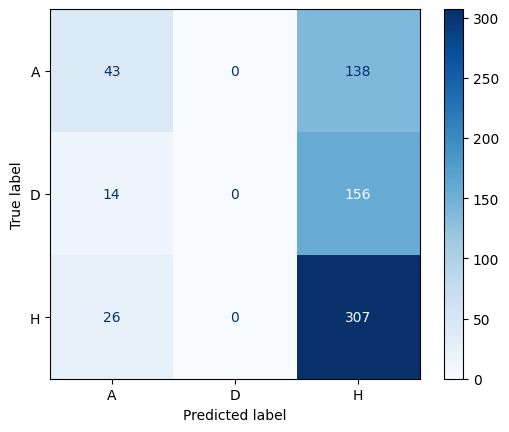

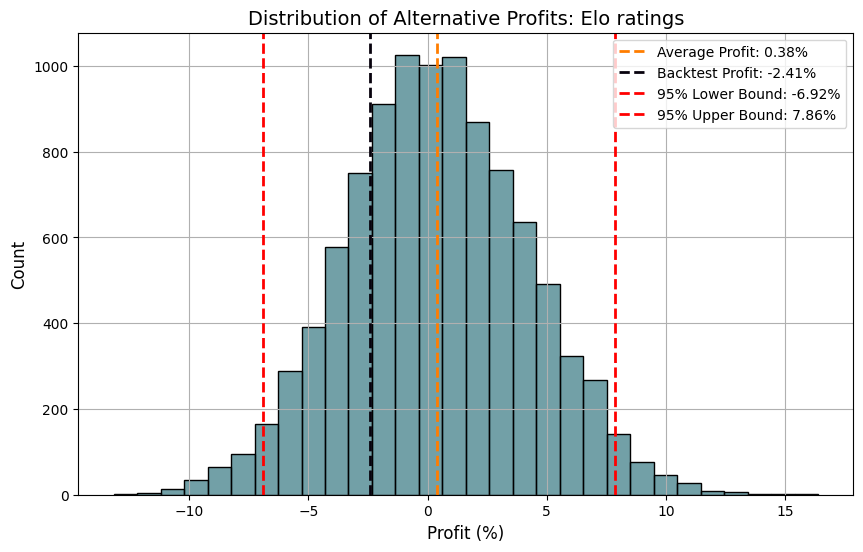


Summary of random effect analysis
  Average profit over simulations: 0.38%
  95% interval of profit: [-6.92%, 7.86%]
  Probability of ending better off than in the backtest: 76.89%
  Probability of ending with a loss: 46.75%


In [12]:
_, _ = run_elo_system(df, plot_title = 'Elo ratings', report_ml = False, value_bet = True)

💡 I could have a table here contrasting always home, default elo, and value bets elo. Columns would be sharpness CI, average backtested profit, prob of ending with a loss

As we see, our performance is even worse. This is primarily caused by the fact that our system is bad at predicting the real probability of events happening. Therefore, the instances in which we think we are EV positive are not correct, and we are still EV negative without knowing it.


Before we dive into iterations, let's check how the model is performing in depth. First, the regression, which is at the core of our model. If we used all of the data we gathered on ranking differences and outcomes, which spans from 2015 to 2024, and trained a logistic regression on it (as if we were preparing to bet on the 2025 season), the performance we'd obtain is below.

At the heart of our analysis is recall, a metric that evaluates how many true instances of each category we correctly identified. Formally, recall is defined as

$$
\text{Recall} = \frac{\text{True positives}}{\text{True positives + False negatives}}
$$

and we have one recall score for each category (home, draw, and away).

Recall (weighted): 0.506578947368421
Balanced accuracy: 0.38844066369819014
Log loss: 1.0377255638595944


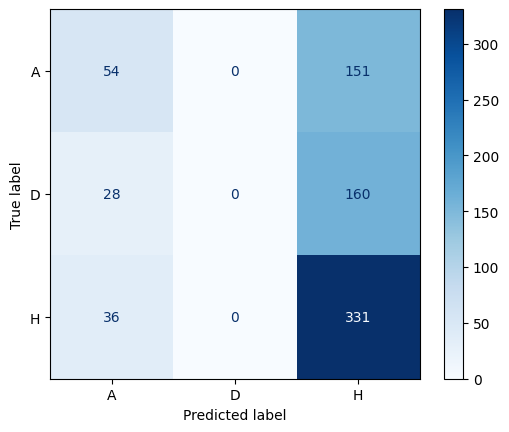

In [ ]:
def check_regression_performance(logit_df):
  # Encode the dependent variable
  label_encoder = LabelEncoder()
  logit_df['outcome_encoded'] = label_encoder.fit_transform(logit_df['outcome'])

  # Isolate independent and dependent variables
  X = logit_df[['rating_diff']].values
  y = logit_df['outcome_encoded'].values

  # Split data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Define and fit the logistic regression model on the training data
  model = LogisticRegression(solver='lbfgs')
  model.fit(X_train, y_train)

  # Generate predictions on the test data
  y_pred = model.predict(X_test)
  y_prob = model.predict_proba(X_test)

  # Compute key metrics
  cm = confusion_matrix(y_test, y_pred)
  recall = recall_score(y_test, y_pred, average='weighted')
  loss = log_loss(y_test, y_prob)
  balanced_acc = balanced_accuracy_score(y_test, y_pred)

  print(f'Recall (weighted): {recall}')
  print(f'Balanced accuracy: {balanced_acc}')
  print(f'Log loss: {loss}')

  # Display the confusion matrix
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
  disp.plot(cmap="Blues")

check_regression_performance(logit_df)

From the confusion matrix, we can infer and quantify some of the regression's behavior. Three aspects that are immediately noticeable are:
1. The regression is overconfident about home victories, predicting this to be the right outcome 84% of the time when, in fact, this outcome only corresponds to 48% of our data
2. The regression is underconfident about away victories, guessing this outcome only 15% of the time when, in the data, it actually happened in 26% of matches
3. Like the wisdom of the crowds, the regression never predicts draws to be the most likely outcome.

The confusion matrix also allows us to arrive at two of the other metrics we are tracking, balanced accuracy and weighted recall. Looking at each individual category, out of all instances when a match finished in a home victory, draw, and away victory, the regression guessed it correctly 90%, 0%, and 26% of the time, respectively. Taking the average between these ratios, we have a balanced accuracy of 38% overall. However, if we account for the fact that categories are not equally present in the dataset, and home victories, for example, are nearly twice as common as away victories, the weighted recall goes up to 50%. Still, this performance is suboptimal, and rather than capturing the underlying behavior correctly, the regression seems to be always guessing home victories because it knows this is the most likely outcome.

This naturally raises a question: is the mode;l not performing well due to parameter mispecification? Or is the regression simply not powerful enough for the job at hand? 🚨 Explain here why changing omega of dataset length might make sense.

# Hyperparameter estimation

Hyperparameter search. Low hanging fruits are:
- How many past seasons are included each time the regression is trained
- values for k and omega in the Elo function

We want a parameter configuration that enhances our performance as a whole. This means increasing the number of correct bets we place every season. Given that we re-fit the regression at the beginning of every season, the previous seasons will serve the purpose of train data and the present season of test data.

During the seasons [2019-2024], we will evaluate the average win ratio of each parameter configuration, using this as the function to be optimized.

In [ ]:
# Parameter ranges to be evaluated
omegas = [i for i in range(50, 750, 50)]
k0s = [i for i in range(5, 60, 5)]
logit_seasons_cutoff = [i for i in range(1, 12, 2)]


calibration_seasons = [2012, 2013, 2014]
logit_seasons = [2015, 2016, 2017, 2018]
betting_seasons = [2019, 2020, 2021, 2022, 2023, 2024]

def test_parameters(omegas, k0s, logit_seasons_cutoff, calibration_seasons, logit_seasons, betting_seasons):

  log = pd.DataFrame(columns=['omega', 'k0', 'cutoff', 'AWR', 'IWR'])
  max_win_ratio = 0

  for omega in omegas:
    #print(f'Omega: {omega}')
    for k0 in k0s:
      #print(f'K0: {k0}')
      for cutoff in logit_seasons_cutoff:

        # Runs backtest from scratch with each performance config
        ratings_dict = run_elo_calibration(df, calibration_seasons, c=10, d=400, omega=omega, k0=k0)
        ratings_dict, logit_df = run_logit_calibration(df, logit_seasons, ratings_dict, c=10, d=400, omega=omega, k0=k0)
        _, betting_log = run_elo_bets(df, logit_df, betting_seasons, ratings_dict, c=10, d=400, omega=omega, k0=k0, max_past_seasons = cutoff, report = False)

        # Calculates percentage of correct bets for each season and overall
        individual_win_ratios = []
        for season in betting_seasons:
          season_df = betting_log[betting_log['Season'] == season]
          individual_win_ratios.append(season_df['Successful bets'].sum()/len(season_df))

        avg_win_ratio = betting_log['Successful bets'].sum()/len(betting_log)

        # Logs results
        log.loc[len(log)] = {'omega': omega, 'k0': k0, 'cutoff': cutoff, 'AWR': avg_win_ratio, 'IWR': individual_win_ratios}

        # Prints progress
        if avg_win_ratio > max_win_ratio:
          max_win_ratio = avg_win_ratio
          print('\nNEW BEST PERFORMANCE!')
          print(f"omega: {omega}, k0: {k0}, cutoff: {cutoff}y, AWR: {avg_win_ratio}, IWR: {individual_win_ratios}")

  return log

grid_search_log = test_parameters(omegas, k0s, logit_seasons_cutoff, calibration_seasons, logit_seasons, betting_seasons)


NEW BEST PERFORMANCE!
omega: 50, k0: 5, cutoff: 1y, AWR: 0.4763157894736842, IWR: [0.50263158 0.46052632 0.47631579 0.46315789 0.46315789 0.49210526]

NEW BEST PERFORMANCE!
omega: 50, k0: 5, cutoff: 3y, AWR: 0.4802631578947369, IWR: [0.51052632 0.46842105 0.47368421 0.46578947 0.47631579 0.48684211]

NEW BEST PERFORMANCE!
omega: 50, k0: 5, cutoff: 5y, AWR: 0.48464912280701755, IWR: [0.51052632 0.47368421 0.47894737 0.47105263 0.47894737 0.49473684]

NEW BEST PERFORMANCE!
omega: 50, k0: 10, cutoff: 5y, AWR: 0.4859649122807017, IWR: [0.52105263 0.47368421 0.48157895 0.45789474 0.46842105 0.51315789]

NEW BEST PERFORMANCE!
omega: 50, k0: 15, cutoff: 5y, AWR: 0.48728070175438604, IWR: [0.51842105 0.47631579 0.48684211 0.45526316 0.47894737 0.50789474]

NEW BEST PERFORMANCE!
omega: 50, k0: 20, cutoff: 7y, AWR: 0.48815789473684207, IWR: [0.51842105 0.47368421 0.48947368 0.46052632 0.47631579 0.51052632]


The changes to win rate (and, consequently, to the estimated sharpness confidence intervals, had we calculated them) are minimal regardless of the hyperparameters chosen. This likely means that, regardless of the Elo values of each team, which are influenced by omega and K0, the system reaches a level of stability that the logistic regression captures equally. For example, suppose that the intrinsic quality of team A is 40% greater than that of team B. With the original set of parameter, the difference in Elo ratings between both teams was 10 points, but with a new set, it might become 50 points. Regardless of the number, every time two teams have a similar difference in intrinsic quality, the regression learns which number represents that, no matter if it's 10 or 50 points.

Another interesting finding is that, in general, having historical data of large time spans does not influence the quality of the regression meaningfully. Regardless of using one, five, or nine years of historical data at each time we fit the regression, the win ratios are mostly similar. This might be explained by the large amount of observations per season: 380. With such a large number of data points, the regression is able to understand the underlying pattern, even if we have only a single season to look into.

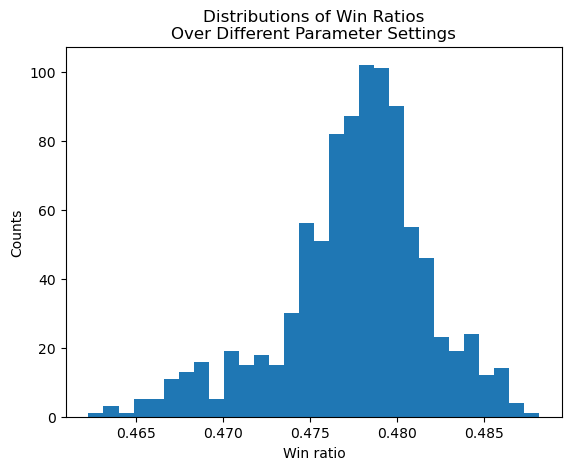

In [ ]:
awr = grid_search_log['AWR'].values

plt.hist(awr, bins = 30)
plt.xlabel('Win ratio')
plt.ylabel('Counts')
plt.title('Distributions of Win Ratios\nOver Different Parameter Settings')
plt.show()

Now, a question one might ask is whether the regression has the same performance for all kinds of ratings. From causal inference, a concept that we could borrow is that of quantile effects, where a treatment affects different segments of the population in different ways. If a government creates a cash transfer program, for example, that targets the 10% poorest individuals in the nation, there is a chance that the people among the 1% poorest benefit
from it very differently from the people among the 9% poorest mark. Similarly, is there a chance that the system is highly accurate in some level of rating difference that could be enough for us to inform bets?

What we want to test here is: when the regression predicts a result with probability between X-Y%, how often does it actually happen?

# Quantile effects

Analyzing quantile effects only makes sense because our model is imperfect. Ideally, had our model been sharp, there would be few differences between our predicted probabilities of each outcome and reality. For example, if our model said the probability of home, draw, and away victory on a given match were 43%, 30%, and 27% respectively, these would closely match sharp lines from the market (such as Pinnacle's) and also match the real probabilities of such events happening. Likewise, had our model been sharp, we would observe around 43% of home victories among the matches where the model's estimation of the probability for a home victory were around 43%. The reason why this matters is that, with accurate estimations of the probabilities of each outcome happening, we can accurately identify value bets and only place wagers in options that leave us positive in expectation. Over a large period of time, if all of our bets have positive EV, our own financial performance should also be positive.

However, our model seems to be far from predicting the correct probabilities, requiring us to try additional factors that could increase our sharpness — and our chances of being positive in expectation. A potential way of improving our bets is to analyze quantile effects. The idea is exploring whether we can create thresholds of ratings differences (or thresholds of predicted probabilities) that leaves us with a high win ratio when we place bets. In simple terms, this means answering questions such as: considering matches where the most likely outcome is predicted to have probabilities between 40%-45%, for example, did the outcome actually happen around 40%-45% of the times? What about in matches where the most likely outcome had a probability between 45%-50%? And so forth and so on. 

We begin by running the same simulation as before, but only up until 2022. This allows us to simulate a bettor's process of having data up to a certain point, making conclusions, and deploying an updated model afterwards (seasons 2023 and 2024) to see how it perform. During the first part of the simulation, we create a dataset that allows us to answer the question: For matches where the model predicted the most likely outcome to have a probability between (A%, B%], how often did the outcome actually happen? Here, A and B take different pre-established values.  

In [ ]:
'''
If we have three outcomes, each gets 33.3%

For a matches where our model predicted the prob of the most likely outcome to be within these buckets,
how often did they actually happen?

33-40
40-45
45-50
50-55
55-60
60-65
65-70
70-75
75-80
80-85

I will perform this analysis between 2019 - 2022, and run an updated version of the betting algorithm based on its results
for 2023 and 2024

in the df:
season, rating difference, model's suggestion of the most likely outcome, prob of this outcome, outcome that actually happened

I then check, for each bucket, how often did we predict the result correctly
'''

In [13]:
def find_most_likely_outcome(model, row, rating_differece):

  best_target = -1 # Just a random value not connected to our categories
  best_prob = -1

  probs = model.predict_proba([[rating_differece]])[0]

  if probs[0] > best_prob:
    best_target = 0
    best_prob = probs[0]

  if probs[1] > best_prob:
    best_target = 1
    best_prob = probs[1]

  if probs[2] > best_prob:
    best_target = 2
    best_prob = probs[2]

  #print(f'Probs: {probs}, what code suggested: {best_target}')

  return best_target, best_prob

In [33]:
# NEW CODE!!!!
def run_elo_bets_verification(df, logit_df, betting_seasons, ratings_dict, plot_title, c=10, d=400, omega=100, k0=10, max_past_seasons=15, threshold = 0, report_ml=False, value_bet = False, odds_picking = True, report_outcomes = True):
  '''
  Runs the same algorithm as before, but with slight modifications to ensure that we collect the necessary data to evaluate quantile effects
  '''
   # Initialize Elo ratings and logistic regression data
  ratings_dict = ratings_dict
  logit_df = logit_df
  logit_df['yhat'] = np.nan
  logit_df['yhat_prob'] = np.nan

  # Initializes lists to store results for each season
  betting_log = pd.DataFrame(columns=['Season', 'Target', 'Result', 'Successful bet', 'Profit/Loss', 'Odds locked', 'Pinnacle OIP'])

  # Loop through the specified betting seasons
  for season in betting_seasons:
   # Train the logistic regression model on the current logit_df and print performance at the last iteration
    if season == betting_seasons[-1]:
      print('\nLogistic regression performance at FINAL SEASON')
      logistic_regression = fit_logistic_regression(logit_df, max_past_seasons, report=True)
    else:
      if report_ml:
        print(f'Logistic regression performance PRE SEASON {season}')
      logistic_regression = fit_logistic_regression(logit_df, max_past_seasons, report=report_ml)

    # Filter data for the current season and adjust ratings for inter-season changes
    season_df = df[df['Season'] == season]
    ratings_dict = adjust_teams_interseason(ratings_dict, season_df)

    # Iterate over each match in the current season
    for index, row in season_df.iterrows():
      # Extract team names, goals, and match outcomes
      teams = [row['Home'], row['Away']]
      goals = [row['HG'], row['AG']]
      elo_outcomes = determine_elo_outcome(row)

      # Predict match outcomes using Elo and logistic regression
      expected_home, expected_away, rating_difference = elo_predict(c, d, omega, teams, ratings_dict)

      # Decides what to bet on
      if value_bet == True:
        yhat, yhat_prob = find_value_bet(logistic_regression, row, rating_difference, odds_picking)
      else:
        yhat, yhat_prob = find_most_likely_outcome(logistic_regression, row, rating_difference)

      # Places bets
      if (yhat != -1) and yhat_prob > threshold: # When looking for value bets, "-1" represents that no bets should be placed
        target = 'A' if yhat == 0 else 'D' if yhat == 1 else 'H'
        result = row['Res']
        successful_bet = 1 if target == result else 0
        odds_locked = row[f'MaxC{target}'] if odds_picking else row[f'AvgC{target}']
        profit_loss = (odds_locked - 1) if successful_bet else -1
        pinnacle_odds_implied_probability = (1/row[f'PSC{target}']) / ( (1/row['PSCH']) + (1/row['PSCD']) + (1/row['PSCA']) )

        # Populates betting log with info specific to each match
        betting_log.loc[len(betting_log)] = {'Season': season,
                                      'Target': target,
                                      'Result': result,
                                      'Successful bet': successful_bet,
                                      'Profit/Loss': profit_loss,
                                      'Odds locked': odds_locked,
                                      'Pinnacle OIP': pinnacle_odds_implied_probability}

      # Update Elo ratings and logistic regression dataset after the match
      ratings_dict = elo_update(k0, expected_home, expected_away, teams, goals, elo_outcomes, ratings_dict)
      logit_df.loc[len(logit_df)] = {'season': season, 'rating_diff': rating_difference, 'yhat': yhat, 'yhat_prob': yhat_prob, 'outcome': row['Res']}

  # Runs analysis of results and isolates posterior
  if report_outcomes:
    posterior_samples = summarize_results(betting_seasons, betting_log, plot_title)
  else:
    posterior_samples = []
    
  return posterior_samples, betting_log, logit_df

We run the code again and print a summary once more. We don't expect this summary to be any relevant to the one we had before, and the reason we print it is just to use it as a sanity check and ensure that the modifications we did to the code didn't break it in unexpected ways. (As we see below, it didn't).


Logistic regression performance at FINAL SEASON
Recall (weighted): 0.5285087719298246
Balanced accuracy: 0.37626559266096105
Log loss: 0.9946017116410076



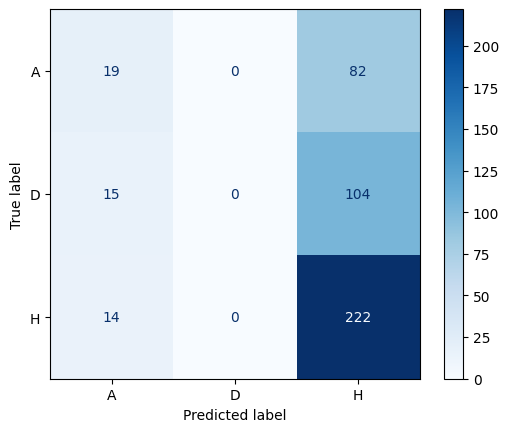

In [17]:
calibration_seasons = [2012, 2013, 2014]
logit_seasons = [2015, 2016, 2017, 2018]
quantile_seasons = [2019, 2020, 2021]

ratings_dict = run_elo_calibration(df, calibration_seasons)
ratings_dict, logit_df = run_logit_calibration(df, logit_seasons, ratings_dict)
_, _, logit_df = run_elo_bets_verification(df, logit_df, quantile_seasons, ratings_dict, plot_title = 'Elo system: temporary', report_outcomes = False)

At this point, it is as if we were right at the end of 2021, getting ready to bet on the 2022 season. We then analyze the dataset to understand if setting a threshold can help the model perform better.

In [18]:
# Encode the dependent variable
label_encoder = LabelEncoder()
logit_df['outcome_encoded'] = label_encoder.fit_transform(logit_df['outcome'])
logit_df = logit_df[logit_df['season'] > 2018]
logit_df['yhat_prob'] = logit_df['yhat_prob']*100
logit_df

,season,rating_diff,outcome,yhat,yhat_prob,outcome_encoded
1519,2019,68.928967,H,2.0,56.595145,2
1520,2019,187.149836,H,2.0,65.591883,2
1521,2019,-96.969517,H,2.0,42.918314,2
1522,2019,133.125191,H,2.0,61.606071,2
1523,2019,56.885333,A,2.0,55.628096,0
...,...,...,...,...,...,...
2654,2021,-186.990901,H,0.0,38.006782,2
2655,2021,-144.741835,H,2.0,37.019496,2
2656,2021,66.227189,H,2.0,55.365560,2
2657,2021,127.078392,D,2.0,60.319372,1


In [19]:
def count_matching_instances(df):
    # Define the buckets for yhat_prob
    buckets = [(33, 40), (40, 45), (45, 50), (50, 55), (55, 60),
               (60, 65), (65, 70), (70, 75), (75, 80), (80, 85), (85, 100)]

    # Create a list to store the rows for the table
    table_data = []

    # Iterate over each bucket
    for lower, upper in buckets:
        # Filter the dataframe to include only rows where yhat_prob is within the current bucket
        bucket_df = df[(df['yhat_prob'] >= lower) & (df['yhat_prob'] < upper)]

        # Count how many times yhat and outcome_encoded are the same
        matching_count = (bucket_df['yhat'] == bucket_df['outcome_encoded']).sum()

        # Calculate the total number of rows in the bucket
        total_count = len(bucket_df)

        # Calculate the percentage of matching instances
        if total_count > 0:
            matching_percentage = (matching_count / total_count) * 100
        else:
            matching_percentage = 0.0

        # Append the result as a row in the table
        table_data.append([f"{lower}-{upper}", matching_count, f"{matching_percentage:.2f}%"])

    # Print the table using tabulate
    headers = ["Bucket (%)", "Count of Matches where\nRegression Guessed Correctly", "Percentage of All Matches"]
    print(tabulate(table_data, headers=headers, tablefmt="pretty"))

count_matching_instances(logit_df)

+------------+------------------------------+---------------------------+
| Bucket (%) |    Count of Matches where    | Percentage of All Matches |
|            | Regression Guessed Correctly |                           |
+------------+------------------------------+---------------------------+
|   33-40    |              73              |          40.11%           |
|   40-45    |              87              |          43.28%           |
|   45-50    |              77              |          49.36%           |
|   50-55    |              74              |          43.79%           |
|   55-60    |              72              |          48.98%           |
|   60-65    |              82              |          63.08%           |
|   65-70    |              53              |          62.35%           |
|   70-75    |              37              |          71.15%           |
|   75-80    |              10              |          58.82%           |
|   80-85    |              1         

In general, the predicted probability for the most likely outcome is, indeed, in line with what happens in reality. We theoretically would enhance our sharpness if we constrained the model to only placing bets when the certainty about the outcome is greater than a certain threshold. Given our RBEP in the initial implementation was 0.48, we set a threshold greater than that, such as 60%, to see how our performance changes.


Logistic regression performance at FINAL SEASON
Recall (weighted): 0.5014619883040936
Balanced accuracy: 0.37018877878704465
Log loss: 1.0214796135873472

Season-specific results
╒══════════╤═══════════════╤═══════════════════╤════════════════╤══════════════════╤════════╤══════════════╕
│  Season  │  Bets Placed  │  Successful Bets  │  Sharpness CI  │  Sharpness Mean  │  RBEP  │  Profit (%)  │
╞══════════╪═══════════════╪═══════════════════╪════════════════╪══════════════════╪════════╪══════════════╡
│   2022   │      68       │        45         │ [0.544, 0.765] │       0.66       │  0.66  │     1.68     │
├──────────┼───────────────┼───────────────────┼────────────────┼──────────────────┼────────┼──────────────┤
│   2023   │      68       │        44         │ [0.533, 0.753] │       0.64       │  0.62  │     5.29     │
├──────────┼───────────────┼───────────────────┼────────────────┼──────────────────┼────────┼──────────────┤
│   2024   │      54       │        36         │ [0.536, 

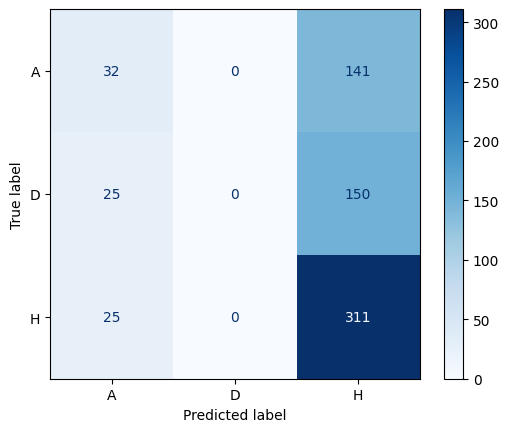

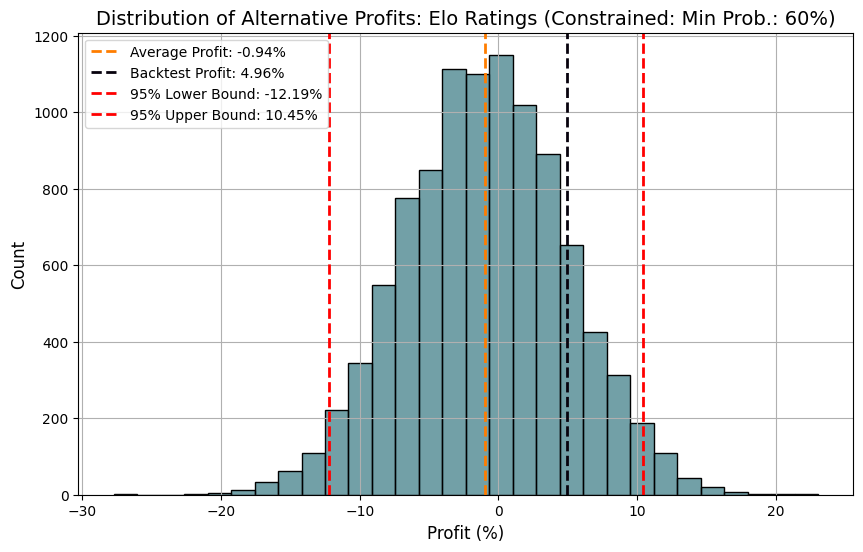


Summary of random effect analysis
  Average profit over simulations: -0.94%
  95% interval of profit: [-12.19%, 10.45%]
  Probability of ending better off than in the backtest: 15.39%
  Probability of ending with a loss: 56.42%


In [35]:
calibration_seasons = [2012, 2013, 2014]
logit_seasons = [2015, 2016, 2017, 2018, 2019, 2020, 2021]
quantile_seasons = [2022, 2023, 2024]

ratings_dict = run_elo_calibration(df, calibration_seasons)
ratings_dict, logit_df = run_logit_calibration(df, logit_seasons, ratings_dict)
posterior_elo_constrained, betting_log, logit_df = run_elo_bets_verification(df, logit_df, quantile_seasons, ratings_dict, plot_title = 'Elo Ratings (Constrained: Min Prob.: 60%)', threshold = 0.6)

What we observe by constraining the regression is that, indeed, our sharpness is enhanced; the new sharpness credible interval are considerably greater than the previous one. However, our profit stays nearly the same. Despite the fact that, during the backtests, we obtained positive results, the Monte Carlo simulations demonstrate that, in expectation, we are still negative in expectation and roughly with the same probability of ending with a loss. This can be explained by the fact that the bookmakers also took into account the skill level of the teams involved, meaning that they also knew the outcomes we were betting on were the most likely. Given that, the odds offered were lower, which prevented us from becoming positive in expectation despite the higher sharpness.